In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import bisect
import math
import bisect

from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def timer(f):
    def countTime(*args, **kwargs):
        print("Start timing...")
        s = time.time()
        res = f(*args, **kwargs)
        e = time.time()
        print("End timing.")
        print("Processed in %f seconds." %(e-s))
        return res
    return countTime

In [3]:
# Convert scalar function to vector function
def vecfunc(f):
    return np.frompyfunc(f,1,1)

In [4]:
# Monte Carlo simulation
def monteCarlo(steps: int, weights: np.array, mult: np.array) -> np.array:
    # weights = eigenvalue vector
    # mult = multiplicity vector
    dimension = len(weights)
    alpha = mult/2
    rvec = np.random.dirichlet(alpha, size = steps)
    col = np.dot(rvec, weights)
    return sorted(col)

In [5]:
# Integral operator, use Simpson formula here
def operator(tsteps:int, xsteps: int, lam: float, m: int, n: int, f): 
    
    # Convert CDF to integral core
    x = np.dot(np.linspace(0, 1, 2*xsteps+1).reshape(2*xsteps+1, 1),np.ones(tsteps+1).reshape(1, tsteps+1))
    y = np.dot(np.ones(2*xsteps+1).reshape(2*xsteps+1, 1),np.linspace(0, 1, tsteps+1).reshape(1, tsteps+1))
    intCore = (y-lam*x)/(1-x)
    intCore[np.isnan(intCore)] = lam
    intCore[np.isinf(intCore)] = 1
    intCore = f(intCore)
    
    # Plot figure of integral core
    """
    fig = plt.figure()
    ax = Axes3D(fig)
    X, Y = np.meshgrid(np.linspace(0,1,tsteps+1),np.linspace(0,1,2*xsteps+1))
    plt.xlabel("x")
    plt.ylabel("y")
    ax.plot_surface(X,Y,intCore,rstride=1,cstride=1,cmap="rainbow")
    """
    
    # Beta density function
    betaFunc = lambda x: beta.pdf(x, m/2, n/2)
    betaFunc = np.frompyfunc(betaFunc, 1, 1)
    betaDens = np.linspace(0, 1, 2*xsteps+1)
    betaDens = betaFunc(betaDens)
    betaDens[0] = 0
    betaDens[-1] = 0
    
    # Simpson formula
    betaDens[2:2*xsteps:2] *= 2
    betaDens[1:2*xsteps:2] *= 4
    betaDens /= 6*xsteps
    
    # Integrate
    return np.dot(betaDens, intCore)

In [6]:
def dist(mx,my,nx,ny):
    
    @vecfunc
    def bis(x) -> int:
        return bisect.bisect_left(mx,x)
    
    pos = bis(nx)
    pos = pos.astype(int)
    pos = np.delete(pos,[0,-1])
    l = len(pos)
    dist = (np.array(my)[pos]-np.array(my)[pos-1])*(np.array(nx)[1:l+1]-np.array(mx)[pos-1])/(np.array(mx)[pos]-np.array(mx)[pos-1])
    dist = np.array(ny)[1:l+1]-np.array(my)[pos-1]-dist
    return dist, l

In [7]:
weights = np.array([0, 1, 0.3])
mult = np.array([1, 1, 1])

In [8]:
steps = 10**6
mx = np.linspace(0, 1, steps)
my = monteCarlo(steps, weights, mult)

In [9]:
# CDF of S_n-1 # cdf of lambda = (0,1), m = (1,1)
@vecfunc
def cdf(x: float) -> float:
    return math.asin(2*min(1,max(0,x))-1)/math.pi+0.5

xsteps, tsteps = 10**4, 10**2
ix = np.linspace(0, 1, tsteps+1)
iy = operator(tsteps, xsteps, weights[-1], mult[-1], sum(mult)-mult[-1], cdf)

/tmp/ipykernel_95/3317473175.py:7: RuntimeWarning: divide by zero encountered in true_divide
  intCore = (y-lam*x)/(1-x)
/tmp/ipykernel_95/3317473175.py:7: RuntimeWarning: invalid value encountered in true_divide
  intCore = (y-lam*x)/(1-x)


In [10]:
distance, l = dist(my, mx, ix, iy)

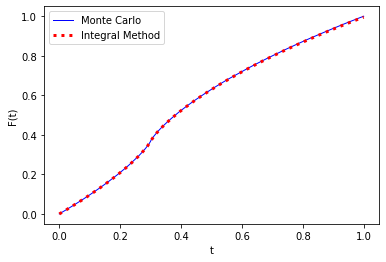

In [11]:
plt.plot(my, mx, ls = "-", lw = 1, color = "blue", label = "Monte Carlo")
plt.plot(ix, iy, ls = ":", lw = 3, color = "red", label = "Integral Method")
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend()
plt.savefig('case1.jpg',dpi = 500)
plt.show()

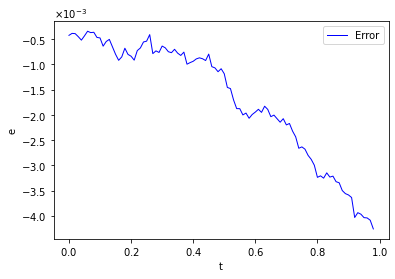

In [20]:
plt.gca().ticklabel_format(style='scientific',scilimits=(-1,0),useMathText=True)
plt.plot(ix[:l], distance.reshape(l), ls = "-", lw = 1, color = "blue", label = "Error")
plt.xlabel('t')
plt.ylabel('e')
plt.legend()
plt.savefig('error1.jpg',dpi = 500)
plt.show()